# Visualize MS COCO

In [59]:
import os
import sys
import json
import warnings
import itertools
import random
warnings.filterwarnings("ignore")
from pathlib import Path
from typing import Any

package_root = os.path.dirname(os.getcwd())
sys.path.insert(0, package_root)

import torch
import torch.nn.functional as nnF
import torchvision.transforms.functional as F

import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
import matplotlib.patches as patches

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("white", {
    "axes.edgecolor": '#475569',
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial',
        'Droid Sans',
        'sans-serif'
    ],
})

%matplotlib inline
# import seaborn as sns
# sns.set()

from sparse_detector.visualizations import ColorPalette
from sparse_detector.datasets.coco import CLASSES

In [47]:
coco_path = Path(package_root) / "data" / "COCO" / "val2017"

# Load coco annotation
with open(coco_path.parent / "annotations" / "instances_val2017.json") as f:
    coco_annos = json.load(f)

annotations = coco_annos['annotations']
def get_annos_for_img(img_id: int) -> Any:
    annos = filter(lambda x: x['image_id'] == img_id, annotations)
    return list(annos)

In [48]:
bboxes = [anno["bbox"] for anno in annotations]
len(bboxes)

36781

In [49]:
stats = dict()

for anno in annotations:
    cat = anno['category_id']
    if cat not in stats:
        stats[cat] = 1
    else:
        stats[cat] += 1

In [50]:
categories = coco_annos['categories']
val_stats = []
for cat_id, count in stats.items():
    cat_item = next(x for x in categories if x["id"] == cat_id)
    val_stats.append({
        "id": cat_id,
        "name": cat_item["name"],
        "instances_count": count
    })

In [51]:
df = pd.DataFrame(val_stats)
df = df.sort_values("instances_count", ascending=False)
df.head()

,id,name,instances_count
19,1,person,11004
13,3,car,1932
10,62,chair,1791
61,84,book,1161
8,44,bottle,1025


Text(0, 0.5, 'Instances count')

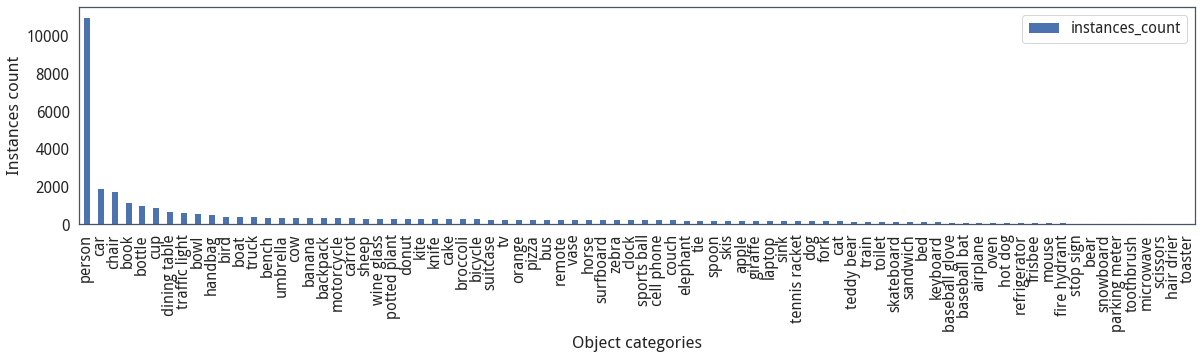

In [52]:
fig, ax = plt.subplots(figsize=(20, 4))
df.plot.bar(x="name", y="instances_count", ax=ax)
ax.set_xlabel("Object categories")
ax.set_ylabel("Instances count")
# fig.savefig("images/train2017_instances_per_category.png", bbox="tight")

**Get the areas of bounding boxes**

In [53]:
area_stats = []
for anno in annotations:
    (x, y, w, h) = anno['bbox']
    area_stats.append({
        "id": anno["id"],
        "bbox_area": w * h
    })

In [54]:
df = pd.DataFrame(area_stats)
df.head()

,id,bbox_area
0,1768,1108.0955
1,1773,42516.6469
2,2551,133036.6085
3,3186,176060.4615
4,3419,100463.2244


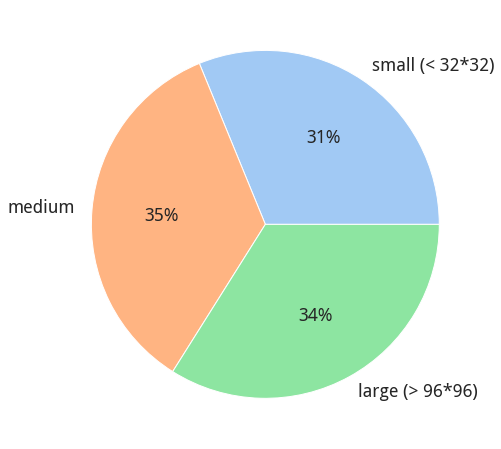

In [55]:
small = df[df.bbox_area < 32*32].count()[0]
medium = df[(df.bbox_area >= 32*32) & (df.bbox_area <= 96*96)].count()[0]
large = df[df.bbox_area > 96*96].count()[0]

total = small +  medium +  large
data = [small / total * 100, medium / total * 100, large / total * 100]
labels = ['small (< 32*32)', 'medium', 'large (> 96*96)']
colors = sns.color_palette('pastel')[0:3]

fig, ax = plt.subplots(figsize=(8, 8))
patches, texts, autotexts = plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%', textprops={'fontsize': 18})
# plt.legend()
fig.set_facecolor('white')
fig.savefig("images/train2017_object_size_dist.png", bbox_inches='tight')
fig.savefig("images/train2017_object_size_dist.pdf", bbox_inches='tight')

**Visualize some sample images**

In [75]:
def get_annos_for_img(img_id: int) -> Any:
    annos = filter(lambda x: x['image_id'] == img_id, annotations)
    return list(annos)

colors = [ColorPalette.ORANGE, ColorPalette.PINK, ColorPalette.YELLOW, ColorPalette.BLUE, ColorPalette.RED, ColorPalette.GREEN]

def get_color_categories(categories):
    avai_colors = colors.copy()
    category_id = set([anno["id"] for anno in categories])
    
    cat_colors = dict()
    for cat_id in category_id:
        if len(avai_colors) == 0:
            avai_colors = colors.copy()
        cat_colors[cat_id] = avai_colors.pop()
    
    return cat_colors

cat_colors = get_color_categories(coco_annos["categories"])

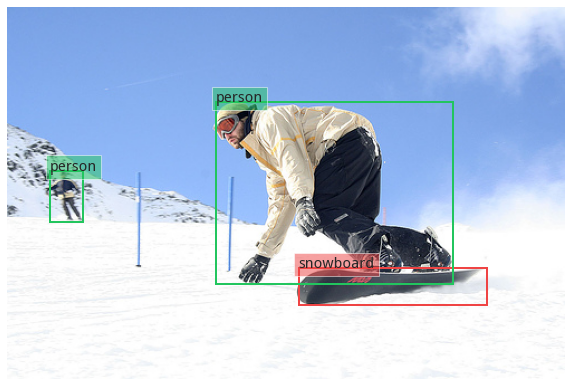

In [85]:
image_id = 350405
img = Image.open(coco_path / (f"{image_id}".rjust(12, '0') + '.jpg'))

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img)
ax.grid(False)
ax.axis("off")

img_annos = get_annos_for_img(image_id)
for img_anno in img_annos:
    category_id = img_anno["category_id"]
    color = cat_colors[category_id]
    x, y, w, h = img_anno['bbox']
    ax.add_patch(patches.Rectangle((x, y), w, h, fill=False, edgecolor=color, lw=2))
    text = f'{CLASSES[category_id]}'
    ax.text(x, y, text, fontsize=15, bbox=dict(facecolor=color, alpha=0.5))

fig.savefig(f"images/annotated_{image_id}.png", bbox_inches="tight")
fig.savefig(f"images/annotated_{image_id}.pdf", bbox_inches="tight")